# FCNs using PyTorch

In [1]:
# import the lib.
import pandas as pd
import numpy as np
# for reading and displaying images
import matplotlib.pyplot as plt
%matplotlib inline
# PyTorch lib. and modules
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

## Load data

In [2]:
# fcn reading ucr
def readucr(filename):    
    data = np.loadtxt(filename)
    Y = data[:,0]
    X = data[:,1:]
    return X, Y

In [3]:
# Read data
fname = 'Trace'
x_train, y_train = readucr(fname+'_TRAIN.txt')
x_test, y_test = readucr(fname+'_TEST.txt')
nb_classes = len(np.unique(y_test))
batch_size = min(x_train.shape[0]/10, 16)
print('classes: ', nb_classes)
print('batch size: ', batch_size)

classes:  4
batch size:  10.0


## Preprocessing the data

In [4]:
# converting type of data
print(x_train.dtype)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
print(x_train.dtype)

float64
float32


In [5]:
# normalization: Min-Max Scaler, range: (0 ~ 1)*nb_classes
y_train = (y_train - y_train.min())/(y_train.max()-y_train.min())*(nb_classes-1)
y_test = (y_test - y_test.min())/(y_test.max()-y_test.min())*(nb_classes-1)

In [6]:
# converting type of data
print(y_train.dtype)
y_train = y_train.astype('int32')
y_test = y_test.astype('int32')
print(y_train.dtype)

float64
int32


In [7]:
# One-Hot-Encoding
Y_train = np.eye(nb_classes)[y_train]
Y_test = np.eye(nb_classes)[y_test]

In [8]:
print(Y_train.dtype)
Y_train = Y_train.astype('int64')
Y_test = Y_test.astype('int64')
print(Y_train.dtype)

float64
int64


In [9]:
print(x_train.shape)
print(x_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(100, 275)
(100, 275)
(100, 4)
(100, 4)


In [10]:
# Standardization: Standard Scaler or z-score normalization (평균 0, 표준 편차 1인 표준분포 꼴 데이터로 만듬)
x_train_mean = x_train.mean()
x_train_std = x_train.std()
x_train = (x_train - x_train_mean)/(x_train_std)
x_test = (x_test - x_train_mean)/(x_train_std)

In [11]:
# slicing: for simple computations test
# nb_slice = 100
# x_train = x_train[:nb_slice][:]
# x_test = x_test[:nb_slice-90][:]
# Y_train = Y_train[:nb_slice][:]
# Y_test = Y_test[:nb_slice-90][:]

In [12]:
# reshape
x_train = x_train.reshape(x_train.shape[0], 1, 1, 275)
x_test = x_test.reshape(x_test.shape[0], 1, 1, 275)
print('x_train: ', x_train.shape)
print('x_test: ', x_test.shape)
print('dtpyes:')
print(x_train.dtype)
print(x_test.dtype)
print(Y_train.dtype)
print(Y_test.dtype)

x_train:  (100, 1, 1, 275)
x_test:  (100, 1, 1, 275)
dtpyes:
float32
float32
int64
int64


In [13]:
# converting numpy.array to tensor
x_train = torch.from_numpy(x_train)
Y_train = torch.from_numpy(Y_train)
x_test = torch.from_numpy(x_test)
Y_test = torch.from_numpy(Y_test)
print('x_train shape: ', x_train.shape, 'Y_train shape: ', Y_train.shape)
print('x_test shape: ', x_test.shape, 'Y_test shape: ', Y_test.shape)
print('dtpyes:')
print(x_train.dtype)
print(x_test.dtype)
print(Y_train.dtype)
print(Y_test.dtype)

x_train shape:  torch.Size([100, 1, 1, 275]) Y_train shape:  torch.Size([100, 4])
x_test shape:  torch.Size([100, 1, 1, 275]) Y_test shape:  torch.Size([100, 4])
dtpyes:
torch.float32
torch.float32
torch.int64
torch.int64


## Implementing CNNs using PyTorch

In [14]:
class FCNs(nn.Module):    
    def __init__(self):
        super(FCNs, self).__init__()        
        self.layer1 = nn.Sequential(                        
            nn.Conv2d(1, 128, kernel_size=(1, 8), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU())            
        self.layer2 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=(1, 5), stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU())
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 128, kernel_size=(1, 3), stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Dropout2d(p=0.2))
        self.fc = nn.Sequential(
            nn.Linear(8704, 128),            
            nn.Linear(128, nb_classes))
        
    def forward(self, x):
        # print('input', x.size())
        out = self.layer1(x)
        # print('layer1', out.size())
        out = self.layer2(out)
        # print('layer2', out.size())
        out = self.layer3(out)
        # print('layer3', out.size())
        out = out.reshape(out.size(0), -1)
        # print('reshape', out.size())
        out = self.fc(out)
        # print('fc', out.size())        
        return out

In [15]:
# defining the model
model = FCNs()
# defining the optimizer
optimizer = optim.Adam(model.parameters(), lr=0.01)
# defining the loss function
criterion = nn.CrossEntropyLoss()
# checking if GPU is available
if torch.cuda.is_available():
    model = model.cuda()
    criterion = criterion.cuda()
    
print(model)

FCNs(
  (layer1): Sequential(
    (0): Conv2d(1, 128, kernel_size=(1, 8), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(1, 5), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (layer3): Sequential(
    (0): Conv2d(256, 128, kernel_size=(1, 3), stride=(2, 2), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.2)
  )
  (fc): Sequential(
    (0): Linear(in_features=8704, out_features=128, bias=True)
    (1): Linear(in_features=128, out_features=4, bias=True)
  )
)


In [16]:
# defining the number of epochs
n_epochs = 500
# empty list to store training losses
train_losses = []
# empty list to store validation losses
val_losses = []

# defining train pro.
def train(epoch):
    model.train()
    tr_loss = 0
    # getting variables
    Xtrain = Variable(x_train)
    Ytrain = Variable(Y_train)
    Xtest = Variable(x_test)
    Ytest = Variable(Y_test)
    # getting the training and testing set
    if torch.cuda.is_available():
        # print('GPU available: ', torch.cuda.is_available())
        Xtrain = x_train.cuda()
        Ytrain = Y_train.cuda()
        Xtest = x_test.cuda()
        Ytest = Y_test.cuda()
    # clearing the Gradients of the model parameters
    optimizer.zero_grad()
    # prediction for training and validation set
    output_train = model(Xtrain)
    output_test = model(Xtest)
    # computing the training and validation loss
    loss_train = criterion(output_train, torch.max(Ytrain, 1)[1])
    loss_test = criterion(output_test, torch.max(Ytest, 1)[1])
    # tensor -> value
    train_losses.append(loss_train.item())
    val_losses.append(loss_test.item())
    # computing the updated weights of all the model parameters
    loss_train.backward()
    optimizer.step()
    # printing the validation loss
    if epoch%1 == 0:        
        print('Epoch : ',epoch+1, '\t', 'loss :', loss_test)
    # clear memory
    del Xtrain, Ytrain, Xtest, Ytest
    del loss_train, loss_test   

In [17]:
# training the model
for epoch in range(n_epochs):
    train(epoch)

Epoch :  1 	 loss : tensor(1.3804, device='cuda:0')
Epoch :  2 	 loss : tensor(39.3595, device='cuda:0')
Epoch :  3 	 loss : tensor(27.6734, device='cuda:0')
Epoch :  4 	 loss : tensor(30.2659, device='cuda:0')
Epoch :  5 	 loss : tensor(31.1450, device='cuda:0')
Epoch :  6 	 loss : tensor(15.6703, device='cuda:0')
Epoch :  7 	 loss : tensor(13.1924, device='cuda:0')
Epoch :  8 	 loss : tensor(13.8626, device='cuda:0')
Epoch :  9 	 loss : tensor(5.4149, device='cuda:0')
Epoch :  10 	 loss : tensor(8.6498, device='cuda:0')
Epoch :  11 	 loss : tensor(6.0487, device='cuda:0')
Epoch :  12 	 loss : tensor(5.1851, device='cuda:0')
Epoch :  13 	 loss : tensor(5.1658, device='cuda:0')
Epoch :  14 	 loss : tensor(4.9805, device='cuda:0')
Epoch :  15 	 loss : tensor(4.5365, device='cuda:0')
Epoch :  16 	 loss : tensor(3.6556, device='cuda:0')
Epoch :  17 	 loss : tensor(3.3306, device='cuda:0')
Epoch :  18 	 loss : tensor(3.4765, device='cuda:0')
Epoch :  19 	 loss : tensor(2.8196, device='cuda

Epoch :  158 	 loss : tensor(1.4223, device='cuda:0')
Epoch :  159 	 loss : tensor(1.4316, device='cuda:0')
Epoch :  160 	 loss : tensor(1.4565, device='cuda:0')
Epoch :  161 	 loss : tensor(1.4459, device='cuda:0')
Epoch :  162 	 loss : tensor(1.4484, device='cuda:0')
Epoch :  163 	 loss : tensor(1.3938, device='cuda:0')
Epoch :  164 	 loss : tensor(1.4498, device='cuda:0')
Epoch :  165 	 loss : tensor(1.4800, device='cuda:0')
Epoch :  166 	 loss : tensor(1.4467, device='cuda:0')
Epoch :  167 	 loss : tensor(1.4454, device='cuda:0')
Epoch :  168 	 loss : tensor(1.4317, device='cuda:0')
Epoch :  169 	 loss : tensor(1.4339, device='cuda:0')
Epoch :  170 	 loss : tensor(1.4391, device='cuda:0')
Epoch :  171 	 loss : tensor(1.4807, device='cuda:0')
Epoch :  172 	 loss : tensor(1.4543, device='cuda:0')
Epoch :  173 	 loss : tensor(1.4395, device='cuda:0')
Epoch :  174 	 loss : tensor(1.4542, device='cuda:0')
Epoch :  175 	 loss : tensor(1.4235, device='cuda:0')
Epoch :  176 	 loss : tensor

Epoch :  318 	 loss : tensor(1.4200, device='cuda:0')
Epoch :  319 	 loss : tensor(1.4207, device='cuda:0')
Epoch :  320 	 loss : tensor(1.4131, device='cuda:0')
Epoch :  321 	 loss : tensor(1.4278, device='cuda:0')
Epoch :  322 	 loss : tensor(1.4503, device='cuda:0')
Epoch :  323 	 loss : tensor(1.4337, device='cuda:0')
Epoch :  324 	 loss : tensor(1.4436, device='cuda:0')
Epoch :  325 	 loss : tensor(1.4216, device='cuda:0')
Epoch :  326 	 loss : tensor(1.4246, device='cuda:0')
Epoch :  327 	 loss : tensor(1.4052, device='cuda:0')
Epoch :  328 	 loss : tensor(1.4061, device='cuda:0')
Epoch :  329 	 loss : tensor(1.4204, device='cuda:0')
Epoch :  330 	 loss : tensor(1.4127, device='cuda:0')
Epoch :  331 	 loss : tensor(1.4235, device='cuda:0')
Epoch :  332 	 loss : tensor(1.4336, device='cuda:0')
Epoch :  333 	 loss : tensor(1.4271, device='cuda:0')
Epoch :  334 	 loss : tensor(1.4275, device='cuda:0')
Epoch :  335 	 loss : tensor(1.4187, device='cuda:0')
Epoch :  336 	 loss : tensor

Epoch :  478 	 loss : tensor(1.4337, device='cuda:0')
Epoch :  479 	 loss : tensor(1.4256, device='cuda:0')
Epoch :  480 	 loss : tensor(1.4111, device='cuda:0')
Epoch :  481 	 loss : tensor(1.4089, device='cuda:0')
Epoch :  482 	 loss : tensor(1.4093, device='cuda:0')
Epoch :  483 	 loss : tensor(1.4129, device='cuda:0')
Epoch :  484 	 loss : tensor(1.4055, device='cuda:0')
Epoch :  485 	 loss : tensor(1.4351, device='cuda:0')
Epoch :  486 	 loss : tensor(1.4548, device='cuda:0')
Epoch :  487 	 loss : tensor(1.4559, device='cuda:0')
Epoch :  488 	 loss : tensor(1.4434, device='cuda:0')
Epoch :  489 	 loss : tensor(1.4476, device='cuda:0')
Epoch :  490 	 loss : tensor(1.4456, device='cuda:0')
Epoch :  491 	 loss : tensor(1.4338, device='cuda:0')
Epoch :  492 	 loss : tensor(1.4323, device='cuda:0')
Epoch :  493 	 loss : tensor(1.4322, device='cuda:0')
Epoch :  494 	 loss : tensor(1.4397, device='cuda:0')
Epoch :  495 	 loss : tensor(1.4306, device='cuda:0')
Epoch :  496 	 loss : tensor

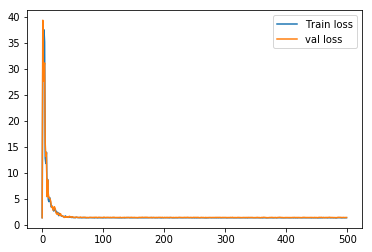

In [18]:
# plotting loss
plt.plot(train_losses, label='Train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()